In [1]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [21]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        print("Appending to queue", i)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.0)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []

    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place

    return random_numbers

In [25]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        print(observation)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [26]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [27]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters

total_episodes = 400
total_test_episodes = 50
max_steps = 999
learning_rate = 0.7
gamma = 0.618
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    arr_rates = generate_random_numbers()
    env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        #print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
        print(reward)
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
-25
Appending to queue 0
[-2.0, 0.0, 0.0]
-25
Appending to queue 0
[-2.5, 0.0, 0.0]
-25
Appending to queue 0
[-3.0, 0.0, 0.0]
-25
Appending to queue 0
[-3.5, 0.0, 0.0]
-25
Appending to queue 0
[-4.0, 0.0, 0.0]
-25
Appending to queue 0
[-4.5, 0.0, 0.0]
1
Appending to queue 0
[-4.5, 0.0, 0.0]
1
Appending to queue 0
[-4.5, 0.0, 0.0]
-25
Appending to queue 0
[-5.0, 0.0, 0.0]
1
Appending to queue 0
[-5.0, 0.0, 0.0]
-25
Appending to queue 0
[-5.5, 0.0, 0.0]
1
Appending to queue 0
[-5.5, 0.0, 0.0]
-25
Appending to queue 0
[-6.0, 0.0, 0.0]
1
Appending to queue 0
[-6.0, 0.0, 0.0]
-25
Appending to queue 0
[-6.5, 0.0, 0.0]
-25
Appending to queue 0
[-7.0, 0.0, 0.0]
1
Appending to queue 0
[-7.0, 0.0, 0.0]
-25
Appending to queue 0
[-7.5, 0.0, 0.0]
1
Appending to queue 0
[-7.5, 0.0, 0.0]
-25
Appending to queue 0
[-8.0, 0.0, 0.0]
1
Appending to queue 0
[-8.0, 0.0, 0.

[0.0, -19.2, 0.0]
-25
[0.0, -19.5, 0.0]
-25
Appending to queue 1
[0.0, -20.5, 0.0]
1
Appending to queue 1
[0.0, -20.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -19.5, 0.0]
1
Appending to queue 1
[-1.0, -19.8, -1.0]
1
Appending to queue 1
[-2.0, -19.2, -2.0]
-10
[-3.0, -19.5, 0.0]
-10
Appending to queue 1
[0.0, -20.5, 0.0]
-25
Appending to queue 1
[0.0, -20.7, 0.0]
1
[0.0, -20.3, 0.0]
-25
Appending to queue 1
[0.0, -21.3, 0.0]
-25
Appending to queue 1
[0.0, -21.5, 0.0]
1
[0.0, -21.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -21.3, 0.0]
-25
Appending to queue 1
[-1.0, -21.5, -1.0]
-10
[0.0, -21.8, -2.0]
1
Appending to queue 1
[0.0, -22.0, -3.0]
-25
Appending to queue 1
[0.0, -22.2, -4.0]
-10
[0.0, -22.5, 0.0]
-25
Appending to queue 1
[0.0, -23.5, 0.0]
1
Appending to queue 1
[0.0, -23.0, 0.0]
-25
[0.0, -23.3, 0.0]
-25
Appending to queue 1
[0.0, -24.3, 0.0]
-25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -24.5, 0.0]


[-14.3, -3.0, -2.0]
1
Appending to queue 0
[-14.5, -4.0, -3.0]
-10
Appending to queue 0
[-14.7, -3.0, -4.0]
1
[-14.3, -4.0, -5.0]
-10
Appending to queue 0
Appending to queue 1
[-15.3, -5.0, 0.0]
1
Appending to queue 0
[-14.7, -3.5, 0.0]
1
[-14.3, -4.5, 0.0]
-25
Appending to queue 0
[-15.3, -5.5, 0.0]
1
Appending to queue 0
Appending to queue 2
[-14.7, -6.5, 0.0]
-10
Appending to queue 1
[-14.3, -7.5, -1.0]
-10
Appending to queue 0
[-14.5, -6.0, -2.0]
1
Appending to queue 0
[-14.0, -7.0, -3.0]
-10
[-13.5, -8.0, -4.0]
-10
Appending to queue 0
[-14.5, -6.5, -5.0]
-10
Appending to queue 0
Appending to queue 1
[-14.0, -7.5, -6.0]
-10
[-13.5, -6.0, -7.0]
-10
Appending to queue 0
[-14.5, -7.0, 0.0]
-10
Appending to queue 0
[-14.7, -5.5, 0.0]
-25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-15.0, -6.5, 0.0]
-10
Episode  22 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
-25
Appending to queue 0
[-

[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, -1.0]
1
[0.0, -1.0, -2.0]
1
Appending to queue 1
[0.0, 0.0, -3.0]
-25
[0.0, -1.0, -4.0]
-25
Appending to queue 1
Appending to queue 2
[0.0, -2.0, -5.0]
-25
[0.0, -2.0, -3.5]
-25
Appending to queue 1
[0.0, -3.0, -4.5]
1
[0.0, -2.0, -5.5]
1
Appending to queue 1
[0.0, -3.0, -4.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -3.0, 0.0]
1
[-1.0, -2.3, -1.0]
1
Appending to queue 1
[0.0, -3.3, -2.0]
-25
[0.0, -3.5, -3.0]
-25
Appending to queue 1
[0.0, -4.5, -4.0]
1
Appending to queue 2
[0.0, -3.8, -5.0]
1
Appending to queue 1
[0.0, -4.0, -3.5]
1
[0.0, -3.0, -4.5]
1
Appending to queue 1
[0.0, -3.0, -5.5]
-25
[0.0, -3.0, -6.5]
-25
Appending to queue 1
Appending to queue 2
[0.0, -4.0, -7.5]
1
Appending to queue 1
[0.0, -4.0, -3.5]
1
[0.0, -3.2, -4.5]
1
Appending to queue 1
[0.0, -4.2, -3.0]
1
[0.0, -3

[-1.0, -14.0, -1.0]
-10
Appending to queue 0
[0.0, -13.4, -2.0]
1
[-1.0, -12.9, -3.0]
-10
Appending to queue 0
Appending to queue 1
[0.0, -13.9, -4.0]
1
[-1.0, -11.8, -5.0]
-10
[-2.0, -12.8, 0.0]
1
Appending to queue 0
Appending to queue 1
[-3.0, -12.1, 0.0]
1
[-2.5, -10.0, 0.0]
-10
Appending to queue 0
[-2.0, -11.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-2.0, -10.5, 0.0]
-10
[-2.0, -10.0, -1.0]
1
Appending to queue 0
[-3.0, -9.5, -2.0]
-10
[-1.0, -10.5, -3.0]
-10
Appending to queue 0
Appending to queue 1
[0.0, -11.5, -4.0]
-25
[-1.0, -10.9, -5.0]
-10
[-2.0, -11.9, 0.0]
-10
Appending to queue 0
Appending to queue 1
[0.0, -12.9, 0.0]
-25
[-1.0, -12.2, 0.0]
-10
Appending to queue 0
[0.0, -13.2, 0.0]
-25
Appending to queue 1
Appending to queue 2
[-1.0, -14.2, 0.0]
-25
Appending to queue 0
[-2.0, -13.7, -1.0]
1
[-2.0, -13.1, -2.0]
-10
Appending to queue 1
[-2.0, -14.1, -3.0]
1
Appending to queue 0
[-3.0, -12.0, -4.0]
-10
[-1.0, -13.0, -5.0]
-10
Appending to queue 0
Appending to

25
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
-25
Appending to queue 1
Appending to queue 2
[-2.0, 0.0, -2.0]
1
Appending to queue 0
[-3.0, -1.0, -1.0]
1
[-2.5, 0.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, -3.0]
1
[-1.0, 0.0, -2.5]
1
Appending to queue 1
Appending to queue 2
[-2.0, 0.0, -2.0]
1
Appending to queue 0
[-3.0, -1.0, -1.0]
1
[-2.5, 0.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[-3.5, 0.0, 0.0]
-25
[-3.3, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[-3.0, 0.0, -2.0]
1
Appending to queue 0
[-3.0, -1.0, -2.0]
1
[-1.0, -2.0, -3.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -3.0, -4.0]
1
[-1.0, -4.0, -2.5]
1
Appending to queue 1
Appending to queue 2
[0.0, -5.0, -3.5]
1
Appending to queue 0
[0.0, -1.0, -3.3]
1
[-1.0, 0.0, -4.3]
1
Appending to queue 2
[0.0, 0.0, -5.3]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -3.7]
-25
Appending to queue 2
[-1.0, -1.0, -4.7]
1
Appending to queue 0
[-2.

Appending to queue 0
Appending to queue 2
[-5.0, -1.0, -5.0]
1
[-4.2, -2.0, -3.5]
1
Appending to queue 0
[-4.2, -3.0, -4.5]
1
[-3.5, -4.0, -5.5]
1
Appending to queue 0
Appending to queue 1
[-4.5, -5.0, -4.0]
1
Appending to queue 2
[-3.8, -3.5, -5.0]
1
Appending to queue 0
[-4.8, -2.0, -3.5]
1
[-4.0, -3.0, -4.5]
1
Appending to queue 0
[-5.0, -4.0, -3.0]
1
[-4.0, -5.0, -4.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-4.0, -6.0, -5.0]
1
[-3.0, -4.0, -3.5]
1
Appending to queue 0
[-3.0, -5.0, -4.5]
1
[-2.0, -6.0, -5.5]
1
Appending to queue 0
[-2.0, -7.0, -6.5]
-10
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.0, -8.0, -7.5]
-10
Episode  90 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
-25
Appending to queue 0
[-2.0, -2.0, 0.0]
1
[-2.0, 0.0, 0.0]
-25
Appending to queue 0
Appending to queue 1
[-3.0, 0.0, 0.0]
1
[-2.0, -1.0, 0.0]
1
Appending to queue 0


Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, 0.0, -1.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, -1.0, -1.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 2
[0.0, -3.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[0.0, -1.0, -1.5]
1
Appending to queue 2
[0.0, 0.0, -2.5]
-25
[0.0, 0.0, -2.7]
1
Appending to queue 2
[0.0, 0.0, -3.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
[0.0, 0.0, -1.5]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, -1.0, -1.

[-2.5, 0.0, -4.0]
1
Appending to queue 1
[-2.0, 0.0, -3.0]
1
Appending to queue 0
[0.0, -1.0, -4.0]
1
Appending to queue 2
[-1.0, 0.0, -5.0]
1
[0.0, 0.0, -4.3]
-25
Appending to queue 0
[0.0, 0.0, -5.3]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -4.5]
1
[0.0, -1.0, -4.0]
1
Appending to queue 0
[0.0, -2.0, -3.5]
1
[-1.0, -3.0, -3.0]
1
Appending to queue 2
[0.0, -4.0, -4.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -3.0]
1
[-1.0, -1.0, -2.0]
1
Appending to queue 2
[0.0, -2.0, -3.0]
1
Appending to queue 0
[0.0, -3.0, -1.0]
1
[-1.0, -4.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -5.0, 0.0]
-25
Episode  130 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0


Appending to queue 0
[-4.9, 0.0, -13.0]
1
Appending to queue 0
[-4.7, 0.0, -14.0]
1
Appending to queue 0
Appending to queue 2
[-4.6, 0.0, -15.0]
1
Appending to queue 0
[-4.4, 0.0, -11.0]
1
Appending to queue 0
[-4.3, 0.0, -12.0]
-25
Appending to queue 0
[-4.8, 0.0, -13.0]
1
[-4.6, 0.0, -14.0]
1
Appending to queue 0
[-5.0, 0.0, -15.0]
1
Appending to queue 0
[-4.9, 0.0, -16.0]
1
Appending to queue 0
[-4.7, 0.0, -17.0]
1
Appending to queue 0
[-4.6, 0.0, -18.0]
-10
Appending to queue 0
[-5.0, 0.0, -14.0]
1
Appending to queue 0
Appending to queue 2
[-4.9, 0.0, -15.0]
1
Appending to queue 0
[-4.8, 0.0, -11.0]
1
[-4.6, 0.0, -12.0]
1
Appending to queue 0
[-5.0, 0.0, -13.0]
1
Appending to queue 0
[-4.9, 0.0, -14.0]
-25
Appending to queue 0
[-5.2, 0.0, -15.0]
1
Appending to queue 0
[-5.1, 0.0, -16.0]
1
Appending to queue 0
[-5.0, 0.0, -17.0]
1
Appending to queue 0
[-4.9, 0.0, -18.0]
1
Appending to queue 0
[-4.8, 0.0, -19.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-4.6, 

[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -2.0, 0.0]
1
[-1.0, -2.0, -1.0]
1
Appending to queue 1
[-2.0, 0.0, -2.0]
1
Appending to queue 2
[-3.0, -1.0, 0.0]
1
Appending to queue 1
[-4.0, 0.0, -1.0]
1
Appending to queue 2
[-5.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, -1.0]
1
[0.0, -1.0, -2.0]
-25
Appending to queue 1
Appending to queue 2
[0.0, -2.0, -3.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, -3.0, 0.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 1
[0.0, -2.0, -2.0]
1
Appending to queue 2
[0.0, -1.0, -3.0]
1
Appending to queue 1
[0.0, -2.0, -1.0]
1
Appending to queue 2
[0.0, -1.0, -2.0]
1
Appending to queue 1
[0.0, 0.0, -2.0]
1
[0.0, -1.0, -2.0]
1
Appending to queue 2
[0.0, 0.0, -3.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0

25
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 1
[0.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -1.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
-25
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -2.0, 0.0]
1
[-1.0, -1.0, -1.0]
1
[-2.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-3.0, 0.0, 0.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, -2.0, 0.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -2.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, -1.0]
1
[-2.0, -1.0, 0.0]
1
Append

-10
[0.0, -10.1, -7.0]
-25
Appending to queue 1
[0.0, -11.1, -8.0]
-25
Appending to queue 1
[0.0, -11.3, -9.0]
-25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -11.6, -10.0]
1
Episode  199 / 400
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
-25
[-2.0, -1.0, -1.0]
1
Appending to queue 2
[-3.0, 0.0, -2.0]
-25
Appending to queue 2
[-4.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, 0.0, -2.3]
1
Appending to queue 2
[-1.0, 0.0, -2.5]
1
[0.0, 0.0, -2.7]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -3.0]
1
Appending to queue 2
[0.0, -1.0, -2.0]
1
Appending to queue 0
[0.0, -2.0, -1.5]
-25
Appending to queue 2
[-1.0, -3.0, -2.5]
1
[0.0, -4.0, -2.7]
-25
Appending to queue 2
[0.0, -5.0, -3.7]
1
Appending to queue 1
Appending to queue 2
[0.0, -6.0, -3.0]
1
[0.0, -1.0, -3.2]
-25


[0.0, -1.0, -1.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
-25
[-2.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -3.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, -3.0, 0.0]
1
[0.0, -2.5, -1.0]
1
Appending to queue 1
[0.0, -3.5, 0.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
[-1.0, -2.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, -1.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
1
[-2.0, -1.0, 0.0]
1
[-3.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
[-2.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -3.0, 0.0]
1
[-1.0, -1.0, 0.0]
-25
Appending to queue 1
Appending to queue 2
[-2.0, -2.0, 0.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 0
[0.0, -3.0, 0.0]
-25
Appending to queue 1
[-1.0, -4.0, 0.0]
1
[0.0, -3.7, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -3.5, 0.0]
1
[-1.0, -2.0, -1.0]
1
[-2.0, -2.0, -2.0]
1

[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
Appending to queue 2
[-2.0, -1.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, -1.0]
1
Appending to queue 0
[-1.5, 0.0, -2.0]
1
[-1.5, 0.0, -3.0]
1
Appending to queue 0
[-2.0, 0.0, -4.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, -1.0]
1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, -1.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-1.5, 0.

Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, -1.0]
1
[-1.0, 0.0, -2.0]
1
Appending to queue 0
Appending to queue 1
[-2.0, 0.0, 0.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, -1.0]
1
[-1.0, 0.0, -2.0]
-25
Appending to queue 0
[-2.0, 0.0, -3.0]
1
Appending to queue 0
Appending to queue 1
[-2.0, 0.0, 0.0]
1
[-1.5, -1.0, 0.0]
1
Appending to queue 0
[-2.5, 0.0, 0.0]
1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to q

[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -2.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, -1.0]
1
Appending to queue 0
[-1.0, 0.0, -2.0]
1
[-1.0, 0.0, -3.0]
1
Appending to queue 0
[0.0, 0.0, -4.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-2.0, 0.0, -1.0]
1
[-1.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, 0.0, -3.0]
-25
Appending to queue 0
[-1.0, 0.0, -4.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -5.0]
1
Appending to queue 0
[0.0, -1.0, -3.5]
1
[-1.0, 0.0, -4.5]
1
Appending to queue 0
[0.0, 0.0, -5.5]
1
[-1.0, 0.0, -4.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -5.0]
1
Appending to queue 0
[-1.0, 0.0, -1.0]
1
[-1.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, 0.0, -3.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
Append

Appending to queue 0
Appending to queue 1
[-1.0, -3.0, 0.0]
1
Episode  288 / 400
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, -1.0]
1
[-2.0, -1.0, 0.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -1.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 1
[0.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue

Appending to queue 1
[0.0, -2.0, -2.0]
-25
Appending to queue 2
[0.0, -2.0, -3.0]
1
Appending to queue 1
[0.0, -3.0, -1.0]
1
[0.0, -2.0, -2.0]
1
Appending to queue 1
[0.0, -2.0, -3.0]
1
Appending to queue 2
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -1.0]
1
[-1.0, -2.0, 0.0]
1
Appending to queue 2
[-2.0, -2.0, 0.0]
1
Appending to queue 1
[-3.0, 0.0, -1.0]
1
[-4.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, -2.0, 0.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
Appending to queue 1
[0.0, -2.0, -2.0]
1
Appending to queue 2
[0.0, -1.0, -3.0]
1
Appending to queue 1
[0.0, 0.0, -2.5]
1
[0.0, -1.0, -2.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -3.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -2.0, 0.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[

[-2.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 2
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, -2.0, -1.0]
1
Appending to queue 0
[0.0, -3.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, -2.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
[0.0, 0.0, -1.5]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 2
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -1.0]
1
Episode  317 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queu

Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]

Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, -1.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue

Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
Appending to queue 2
[-2.0, -2.0, 0.0]
1
Appending to queue 1
[-3.0, 0.0, -1.0]
1
Appending to queue 2
[-4.0, -1.0, 0.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, -1.0, 0.0]
1
[-2.0, 0.0, -1.0]
1
Appending to queue 1
Appending to queue 2
[-3.0, 0.0, 0.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -

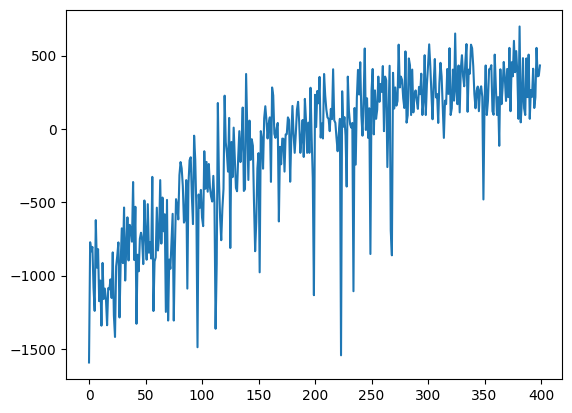

In [29]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [30]:
print(rewardstest)

[-1593, -773, -835, -805, -1084, -1241, -622, -946, -820, -1175, -1034, -1342, -914, -1160, -1089, -1163, -1339, -1086, -1094, -1026, -1153, -842, -1273, -1419, -937, -865, -774, -1286, -919, -678, -915, -536, -1034, -796, -603, -897, -654, -678, -769, -362, -894, -531, -1329, -858, -971, -749, -708, -758, -922, -488, -724, -892, -513, -844, -774, -884, -327, -1242, -904, -876, -537, -829, -733, -349, -782, -468, -698, -582, -1248, -484, -1307, -891, -954, -763, -579, -1307, -813, -479, -521, -617, -315, -226, -269, -389, -639, -616, -349, -1089, -373, -213, -193, -458, -649, -46, -210, -551, -1489, -447, -538, -416, -604, -663, -152, -408, -225, -428, -239, -398, -461, -495, -320, -504, -1363, -919, 177, -351, -605, -759, -545, -410, 227, -91, -167, -291, 75, -812, -89, -329, 9, -195, -402, -425, -194, -15, -226, -91, 146, -423, -411, 375, 17, -348, 57, -211, -70, -115, -508, -834, -635, -269, -165, -978, -15, -67, -271, 73, 155, 61, -65, 35, 79, -361, 283, 229, -33, -61, 6, 41, -631,

In [31]:
# Play the Game
rewards = []

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    state = env.reset()
    print('='*40)
    print("[*] Episode", episode)
    print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        print(reward)
        """"
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        total_rewards += reward
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Episode 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, 0.0, -1.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, -1.0, 0.0]
1
Appending to queue 2
[-3.0, 0.0, -1.0]
1
[-4.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[-5.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[0.0, 0.0, -1.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -1.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 0
[0.

Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[-2.0, 0.0, -1.0]
1
Appending to queue 2
[-3.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[-2.0, 0.0, -1.0]
1
Appending to queue 2
[-3.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -1.0]
1
[*] Score 483
[*] Episode 19
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, 0.

[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[-2.0, 0.0, -1.0]
1
Appending to queue 2
[-3.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[-2.0, 0.0, -1.0]
1
Appending to queue 2
[-3.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, -2.0, -2.0]
1
[0.0, 0.0, -2.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 2
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]